In [1]:
from copy import deepcopy

import gym
import accelerator_environments
import joss
import matplotlib.pyplot as plt
import numpy as np
import ocelot as oc

initializing ocelot...


In [2]:
ocelot_env = gym.make("ARESEA-Ocelot-v0")
joss_env = gym.make("ARESEA-JOSS-v0")

/usr/local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
print(f"Ocelot: {oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).rparticles.shape}")
print(f"JOSS: {joss.generate_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6).shape}")

Ocelot: (6, 100000)
JOSS: (100000, 6)


[ 5.5 -5.5  0.   0.   0. ]
JOSS environment: 0.00012407335199162326 / 5.0448617524469496e-06
Ocelot environment: 0.00020946028171215365 / 8.585133938632083e-05


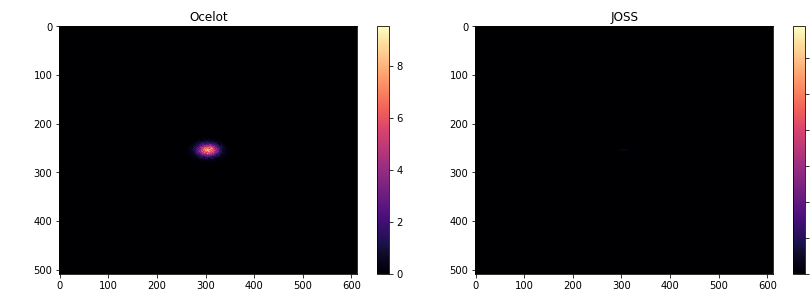

In [10]:
ocelot_env = gym.make("ARESEA-Ocelot-v0")
joss_env = gym.make("ARESEA-JOSS-v0")

observation = ocelot_env.reset()
_ = joss_env.reset()
actuator_values = ocelot_env.read_actuators()
actuator_values[0] = 5.5
actuator_values[1] = -5.5
actuator_values[2] = 0
actuator_values[3] = 0
actuator_values[4] = 0
# joss_env.initial_particles = ocelot_env.initial_particles.rparticles.transpose()
_ = joss_env.objective_function(actuator_values)
_ = ocelot_env.objective_function(actuator_values)
print(actuator_values)

print(f"JOSS environment: {joss_env.particles[:,0].std()} / {joss_env.particles[:,2].std()}")
print(f"Ocelot environment: {ocelot_env.particles.x().std()} / {ocelot_env.particles.y().std()}")

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Ocelot")
plt.imshow(ocelot_env.screen_data, cmap="magma", interpolation="None")
plt.colorbar()
plt.subplot(122)
plt.title("JOSS")
plt.imshow(joss_env.screen_data, cmap="magma", interpolation="None")
plt.colorbar()
plt.tight_layout()
plt.show()

In [11]:
ocelot_env.particles.rparticles.transpose()[:10]

array([[-9.40659448e-05, -2.01876867e-05, -1.22322646e-04,
         4.65122706e-05,  2.05677406e-10,  0.00000000e+00],
       [ 6.08887133e-05,  2.83427816e-06,  1.15133324e-05,
         6.19034687e-05,  3.07209817e-10,  0.00000000e+00],
       [ 1.86364126e-04,  1.56685863e-05,  2.71216263e-05,
         3.17033384e-05,  1.00049807e-10,  0.00000000e+00],
       [-2.54750317e-04, -3.74437090e-05, -8.94203561e-05,
         2.70247997e-05,  1.70591919e-10,  0.00000000e+00],
       [ 1.25196758e-04,  2.98295726e-05,  2.51033029e-07,
         2.58023743e-05,  1.24446898e-10,  0.00000000e+00],
       [ 1.76669287e-04,  6.01899168e-05, -1.20467476e-04,
         1.03624980e-06,  2.89915777e-10,  0.00000000e+00],
       [ 3.57618234e-04,  6.52209637e-05,  1.88999108e-05,
         2.07561434e-05,  3.74772221e-10,  0.00000000e+00],
       [ 1.96080584e-04,  4.61957099e-05, -1.03204917e-04,
         2.86647057e-05,  2.36459805e-10,  0.00000000e+00],
       [ 9.87075155e-05,  2.80552435e-05, -3.352

z = 6.654039999999998 / 6.654039999999998 : applied: Ocelot: 0.00020946916960785705 / 8.571784164844092e-05
JOSS: 0.00020946916960785705 / 8.57178416484409e-05


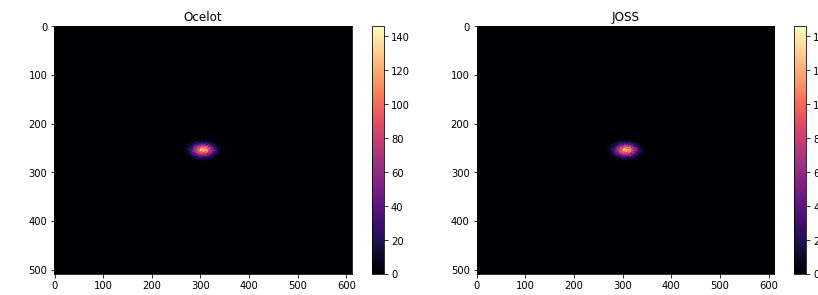

In [12]:
plt.figure(figsize=(12,4))
binning = 4
screen_resolution = (int(2448 / binning), int(2040 / binning))
meter_per_pixel = (3.5488e-6 * binning, 2.5003e-6 * binning)
screen_bin_edges = (np.linspace(-screen_resolution[0]*meter_per_pixel[0]/2,
                                             screen_resolution[0]*meter_per_pixel[0]/2,
                                             screen_resolution[0]+1),
                                 np.linspace(-screen_resolution[1]*meter_per_pixel[1]/2,
                                             screen_resolution[1]*meter_per_pixel[1]/2,
                                             screen_resolution[1]+1))

import accelerator_environments.envs.ares.ARESlatticeStage3v1_9 as aresstuff
from accelerator_environments import utils
cell = utils.subcell_of(aresstuff.cell, "AREASOLA1", "Drift_ARMRBSCR1")
aresstuff.areamqzm1.k1 = actuator_values[0]
aresstuff.areamqzm2.k1 = actuator_values[1]
aresstuff.areamqzm3.k1 = actuator_values[2]
# cell = [oc.Drift(l=3.0), oc.Quadrupole(l=1, k1=0), oc.Drift(l=0), oc.Drift(l=3)]
# cell = [oc.Drift(l=3.0)]

lattice = oc.MagneticLattice(cell)
navigator = oc.Navigator(lattice)
# particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles = oc.generate_parray(nparticles=int(1e+5), sigma_x=175e-6, sigma_y=175e-6, sigma_p=0., chirp=0., energy=0.1, sigma_tau=0.)
particle_array = deepcopy(particles.rparticles)
_, particles = oc.track(lattice, particles, navigator)
image = np.histogram2d(particles.x(), particles.y(),
                       bins=screen_bin_edges)[0].transpose()
print(f"Ocelot: {particles.x().std()} / {particles.y().std()}")

plt.subplot(121)
plt.title("Ocelot")
plt.imshow(image, cmap="magma", interpolation="None")
plt.colorbar()

# particles = joss.generate_particles(n=int(1e+5), sigma_x=175e-6, sigma_y=175e-6)
particles = particle_array.transpose()
transfer_map = joss.ocelot_lattice_2_transfer_matrix(cell)
particles = joss.track(particles, transfer_map)
image = np.histogram2d(particles[:,0], particles[:,2],
                       bins=screen_bin_edges)[0].transpose()
print(f"JOSS: {particles[:,0].std()} / {particles[:,2].std()}")

plt.subplot(122)
plt.title("JOSS")
plt.imshow(image, cmap="magma", interpolation="None")
plt.colorbar()

plt.tight_layout()
plt.show()

In [13]:
np.unique(particle_array[5])

array([0.])